#  TensorBoard

After Training the model, run 

    tensorboard --logdir=path/to/log-directory
    
Tensorboard provides a good visualization tool for all the variables you like and works on a browser.

In [50]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

from IPython.display import Image
from IPython.core.display import HTML 

BATCH_SIZE = 128

In [49]:
def init_weights(shape, name):
    return tf.Variable(tf.random_normal(shape = shape, stddev = 0.01), 
                    name = name)

def model(X, w_h1, w_h2, w_o, p_keep_input, p_keep_hidden):
    #Add layer name scopes for better graph visualization
    with tf.name_scope("layer1"):
        X = tf.contrib.layers.batch_norm(X, scale = True)
        X = tf.nn.dropout(X, p_keep_input)
        h = tf.nn.relu(tf.matmul(X, w_h))
    with tf.name_scope("layer2"):
        h = tf.contrib.layers.batch_norm(h, scale = True)
        h = tf.nn.dropout(h, p_keep_hidden)
        h2 = tf.nn.relu(tf.matmul(h, w_h2))
    with tf.name_scope("layer3"):
        h2 = tf.contrib.layers.batch_norm(h2, scale = True)
        h2 = tf.nn.dropout(h2, p_keep_hidden)
        return tf.matmul(h2, w_o)
    
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, \
                     mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [51]:
tf.reset_default_graph()

X = tf.placeholder("float", [None, 784], name = "X")
Y = tf.placeholder("float", [None, 10], name = "Y")

w_h = init_weights([784, 625], "w_h")
w_h2 = init_weights([625, 625], "w_h2")
w_o = init_weights([625, 10], "w_o")

#Add histogram summaries for weights
tf.summary.histogram("w_h_summ", w_h)
tf.summary.histogram("w_h2_summ", w_h2)
tf.summary.histogram("w_o_summ", w_o)


p_keep_input = tf.placeholder("float", name = "p_keep_input")
p_keep_hidden = tf.placeholder("float", name = "p_keep_hidden")
py_x = model(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden)


with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=py_x, labels = Y))
    train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
    #add scalar summary for cost
    tf.summary.scalar("cost", cost)
    
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(py_x, 1))
    acc_op = tf.reduce_mean(tf.cast(correct_pred, "float"))
    #Add scalar summary for cost
    tf.summary.scalar("accuracy", acc_op)

In [53]:
with tf.Session() as sess:
    #create a log writer. run 'tensorboard --logdir=./logs/nn_logs'
    writer = tf.summary.FileWriter("./logs/nn_logs", sess.graph)
    merged = tf.summary.merge_all()
    
    tf.global_variables_initializer().run()
    k = 0
    for i in range(1):
        for start, end in zip(range(0, len(trX), BATCH_SIZE), 
                              range(BATCH_SIZE, len(trX), BATCH_SIZE)):
            sess.run(train_op, feed_dict = {X: trX[start:end], 
                                            Y: trY[start:end],
                                           p_keep_input: 0.8, 
                                           p_keep_hidden: 0.5})
            summary, acc = sess.run([merged, acc_op], feed_dict = {X: teX, Y: teY,
                                                        p_keep_input: 1.0, 
                                                        p_keep_hidden: 1.0})
            
            writer.add_summary(summary, i) #Write summary
            print("On step {} accuracy {}".format(i, acc))
            k+=1
            if k>10:
                break
        

On step 0 accuracy 0.12099999934434891
On step 0 accuracy 0.13819999992847443
On step 0 accuracy 0.1542000025510788
On step 0 accuracy 0.17710000276565552
On step 0 accuracy 0.2021999955177307
On step 0 accuracy 0.22679999470710754
On step 0 accuracy 0.25290000438690186
On step 0 accuracy 0.2806999981403351
On step 0 accuracy 0.3082999885082245
On step 0 accuracy 0.3352999985218048
On step 0 accuracy 0.3587000072002411


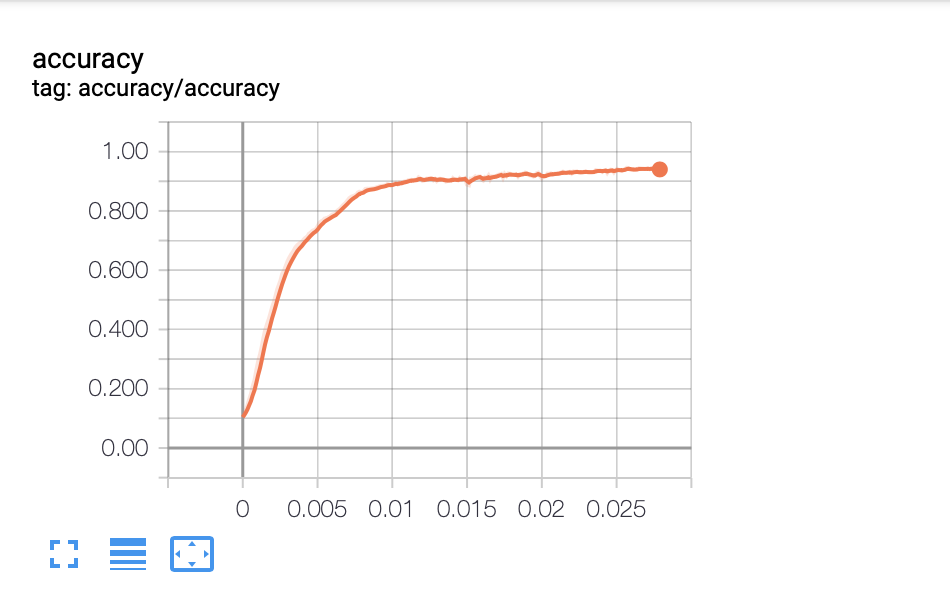

In [54]:
PATH = "tensorboard_imgs/"
Image(filename = PATH + "acc.png")


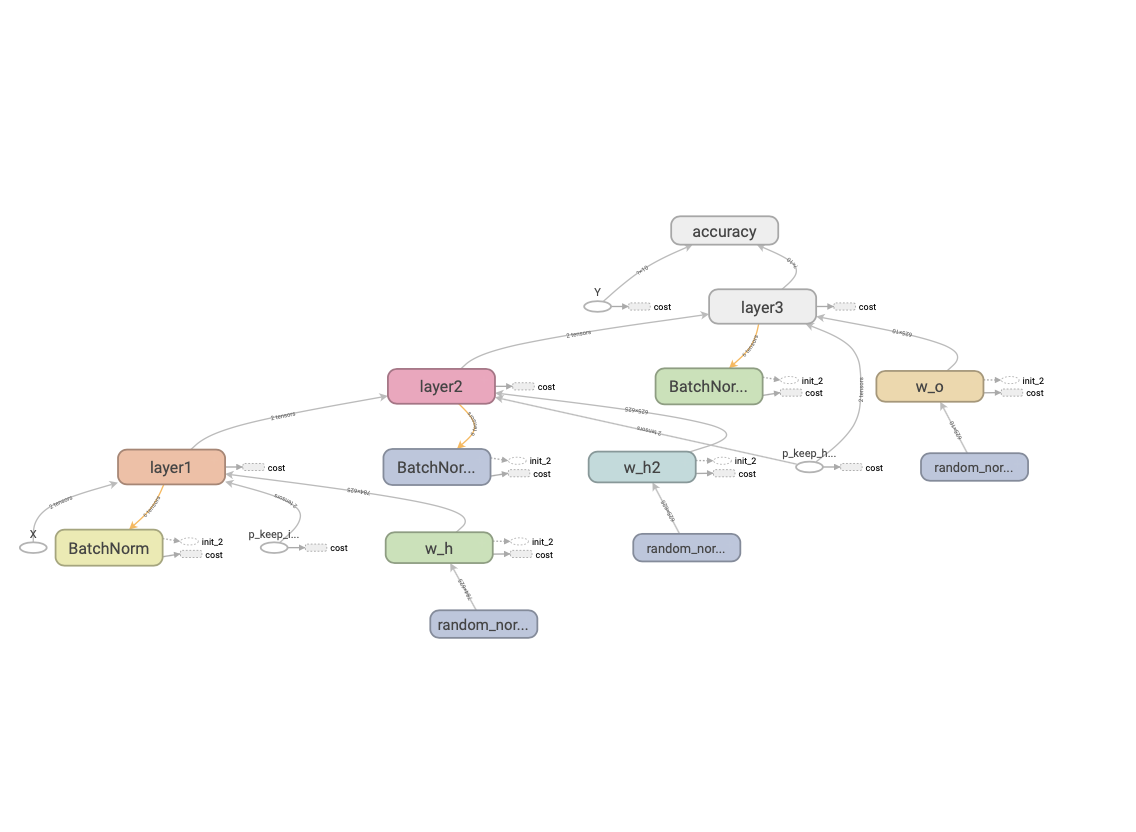

In [55]:

PATH = "tensorboard_imgs/"
Image(filename = PATH + "graph.png")